# A computational account of threat-related attentional bias

# Eye tracking analyses

This notebook performs analysis of the fixation data.

In [1]:
import os
import sys
sys.path.insert(0, '../code')

import pyeparse as pp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib import path
import re
from numpy.lib.recfunctions import append_fields
import pymc3 as pm
import theano
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from eyetracking_functions import *

prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# Random seed
np.random.seed(123)

# Colour palette for plotting
pal = ['#267fd3', '#e88300', '#b21724', '#053c5e', '#5e5e5e']

### Set up directories

These are the directories that contain eye tracking data, behavioural data, and data we've simulated using our winning model.

In [2]:
eyetracking_dir = r'../data/eye_tracking_data'
behavioural_dir = r'../data/behavioural_data'
simulated_dir = r'../data/simulated_data'

### AOIs for both stimuli

Here we define the areas of interest (AOIs) representing the two stimuli. These are defined as matplotlib paths this makes it simple to test whether a point (i.e. a fixation location) is located within them.

In [3]:
left_aoi = path.Path([(-12, -3), (-12, 3), (-6, 3), (-6, -3)])
right_aoi = path.Path([(12, -3), (12, 3), (6, 3), (6, -3)])

## Measure fixation bias

This function separates the raw data into trials, extracts fixations within those trials, and calculates a bias score for each trial representing how much time subjects spend attention to the left vs right stimuli. 

In [4]:
# # # Find subject IDs for those who weren't excluded based on behaviour
subjects = sorted([re.search('\d+', i).group() for i in os.listdir(simulated_dir) if '.txt' in i])

bias_dfs = []

print "Processing eye tracking data for pre-outcome phase, {0} subjects".format(len(subjects))
for n, sub in enumerate(tqdm(subjects)):
    bias_dfs.append(process_fixations(sub, n, 0, 3, eyetracking_dir, behavioural_dir, simulated_dir, left_aoi, right_aoi, '_preoutcome'))

bias_df = pd.concat([i[0] for i in bias_dfs if i is not None])

# Stimuli A & B are randomly shown on left/right - we need to make sure they line up with the eyetracking data
bias_df.bias[bias_df.Outcome_image_L == 'B'] = 1 - bias_df.bias[bias_df.Outcome_image_L == 'B']

# Save
bias_df.to_csv('../data/bias_df.csv')

# Exclude subjects
bias_df = bias_df[bias_df['left_proportion'] > 0.2]
bias_df = bias_df[bias_df['right_proportion'] > 0.2]
bias_df = bias_df[bias_df['outside_proportion'] < 0.8]
bias_df = bias_df[bias_df['blink_proportion'] < 0.3]

print "Number of exclusions = {0}".format(len(subjects) - len(bias_df['Subject'].unique()))

Processing eye tracking data for pre-outcome phase, 48 subjects


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [09:02<00:00,  9.56s/it]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Number of exclusions = 2


### Create variables for modelling

Here we create variables representing the differences in our independent variables between left and right stimuli.

In [5]:
# Transform our outcome variable so that we can use beta regression, which doesn't accept values of 0 or 1.
bias_df['bias'] = (bias_df['bias'] * (len(bias_df) - 1) + 0.5) / len(bias_df)

# Create predictors
bias_df[['prob_estimate_RL_diff', 'var_RL_diff', 'abs_pe_RL_diff', 'model_prob_estimate_RL_diff']] = scale(bias_df[['prob_estimate_RL_diff', 'var_RL_diff', 'abs_pe_RL_diff', 'model_prob_estimate_RL_diff']])

# Get number of subjects
n_subjects = len(bias_df.Subject.unique())

# Create an index variable for subjects
bias_df['Subject_idx'] = np.arange(n_subjects).repeat(len(bias_df) / n_subjects)
subject_idx = bias_df.Subject_idx.values

# Add run ID
bias_df['Run'] = np.tile(np.arange(4).repeat(40), len(bias_df.Subject.unique()))

## Create the model

### Beta regression

The data will be modelled using Bayesian hierarchical beta regression implemented in PyMC3. The outcome variable (proportion of fixation time spent looking at stimulus A) is represented as a beta distribution with unknown parameters $A$ and $B$. 

\begin{equation}
y = \beta(A, B)
\end{equation}

The regression model estimates these parameters by reparameterising the model in terms of mean $\mu$ and precision parameter $\phi$. 

Here $\mu$ is estimated by the standard regression equation with a logistic link function:

\begin{equation*}
\mu = f(a + \beta_1 X_1...\beta_n X_n)
\end{equation*}

For $n$ predictors, with $a$ representing the intercept and $f$ representing the logistic function.

$A$ and $B$ are then calculated as follows:

\begin{equation}
A = \mu \cdot \phi \\
B = (1 - \mu) \cdot \phi
\end{equation}

Precision parameter $\phi$ is assumed to be normally distributed with an exponential transformation:

\begin{equation}
\phi \sim e^{N(0, \sigma^2)}
\end{equation}

### Hierarchical modelling

The data under investigation here has a clear hierarchical structure - we're predicting gaze location within each subject, where each subject is drawn from the larger sample. We can therefore formulate our regression as a hierarchical model with intercepts and slopes that vary across subjects, where we estimate $\mu$ as follows:

\begin{equation}
\mu = a^i + \beta^i_1 X_1...\beta^i_n X_n
\end{equation}

Where $i$ represents the subject, $a$ represents the intercept, and $\beta$ represents the regression coefficient.

### Priors

We specify group-level hyperpriors on the intercept ($a$) and $\beta$ coefficients, and assume that the subject-level estimates are drawn from this group population.

\begin{equation}
a^i = N(\mu, \sigma^2)\\
\beta^i = N(\mu, \sigma^2)
\end{equation}

The $\phi$ parameter is estimated for the model as a whole, and we therefore set a single prior on this, as demonstrated above.

### Centering

Hierarchical models can be difficult to estimate due to correlations between parameters. To avoid this issue, it is common to use a non-centered parameterisation where $\beta$ coefficients are offset from zero by some additional estimated value (https://arxiv.org/abs/1312.0906).

To achieve this, we estimate an offset parameter for each $\beta$ and then use this, along with the estimated $\mu$ and $\sigma$, to determine the $\beta$ value:

\begin{equation}
offset = N(\mu_{offset}, \sigma^2_{offset})\\
\beta = \mu_{\beta} + offset_{\beta} \cdot \sigma_{\beta}
\end{equation}

### Define the model

In [6]:
with pm.Model() as fixation_model:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
    mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
    sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
    b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)
    
    # Precision of reparameterised beta
    phi = pm.HalfCauchy('$\phi$', 100)

    # Estimated y values, with logit link function
    y_est = pm.math.invlogit(b_intercept[subject_idx] +
                             b_value[subject_idx] * bias_df['prob_estimate_RL_diff'] +
                             b_var[subject_idx] * bias_df['var_RL_diff'])
    
    # Beta likelihood
    y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                     observed=bias_df['bias'])

### Fit the model

This is achieved using variational inference - these models take a very long time to run using MCMC and, based on tests comparing the two, vairational inference provides comparable results to MCMC. 

In [7]:
with fixation_model:
    approx = pm.fit(n=80000, random_seed=123)
    trace = pm.sample_approx(approx, draws=1000)
    model_waic = pm.waic(trace)

Average Loss = -8,933.7: 100%|██████████████████████████████████████████████████| 80000/80000 [12:17<00:00, 108.48it/s]
Finished [100%]: Average Loss = -8,933.7


# Results

First, we can get a table giving means, SDs and HPDs for our estimated parameters.

In [8]:
full_summary = pm.summary(trace, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-1.521444,0.018286,0.000601,-1.558782,-1.487094
$\beta$ Estimated probability $\mu$,0.134551,0.017268,0.000584,0.105293,0.171443
$\beta$ Uncertainty $\mu$,-0.004185,0.017526,0.000515,-0.038294,0.028224


We can also plot the sampling trace, along with posterior densities for the parameters.

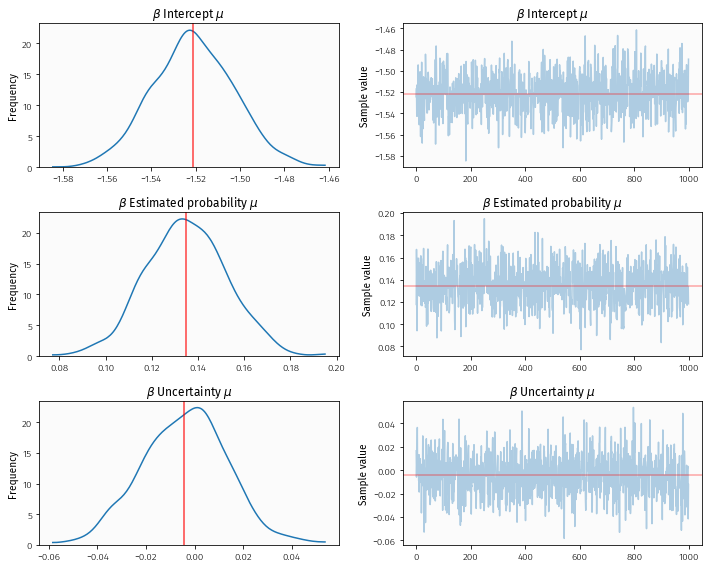

In [9]:
pm.traceplot(trace, lines={'$\\beta$ Intercept $\\mu$':trace['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Estimated probability $\\mu$': trace['$\\beta$ Estimated probability $\\mu$'].mean(),
                           '$\\beta$ Uncertainty $\\mu$': trace['$\\beta$ Uncertainty $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$', 
                       '$\\beta$ Uncertainty $\\mu$'],
             figsize=(10, 8));

And we can make a nice plot to show these results more clearly

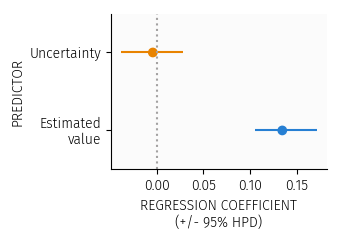

In [10]:
# Remove intercept
summary = full_summary[1:]

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.scatter(summary['mean'], range(len(summary)), color=pal[:3])
plt.errorbar(summary['mean'], range(len(summary)), 
             xerr=[summary['mean'] - summary['hpd_2.5'], summary['hpd_97.5'] - summary['mean']], 
               fmt='none', label=None, color=pal[:3])
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 1.5)
plt.yticks(range(len(summary)), [re.search('[A-Z][a-z ]+', i).group()[:-1].replace(' ', '\n').replace('probability', 'value') for i in summary.index])
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("PREDICTOR", fontweight='light')
sns.despine()

plt.tight_layout()

plt.savefig('../figures/eyetracking_model_estimates.svg', facecolor='#fbfbfb')

## Parameter stability

Here we check whether the parameter estimates are stable by splitting the data in half and fitting the model separately to both halves.

In [11]:
param_estimates = []

for half in [0, 1]:
    
    temp_bias_df = bias_df[(bias_df['Run'] == half * 2) | (bias_df['Run'] == half * 2 + 1)]
    
    with pm.Model() as fixation_model_half:

        # Group-level parameters
        mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
        sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
        mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
        sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
        mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
        sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)

        # Individual-level betas - using non-centered reparameterisation
        intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
        b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

        value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
        b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

        var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
        b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)

        # Precision of reparameterised beta
        phi = pm.HalfCauchy('$\phi$', 100)

        # Estimated y values, with logit link function
        y_est = pm.math.invlogit(b_intercept[subject_idx] +
                                 b_value[subject_idx] * bias_df['prob_estimate_RL_diff'] +
                                 b_var[subject_idx] * bias_df['var_RL_diff'])

        # Beta likelihood
        y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                         observed=bias_df['bias'])
        
    with fixation_model_half:
        approx = pm.fit(n=80000, random_seed=123)
        trace = pm.sample_approx(approx, draws=1000)

    param_estimates.append(pm.summary(trace, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$']))

Average Loss = -8,929.7: 100%|██████████████████████████████████████████████████| 80000/80000 [12:40<00:00, 105.15it/s]
Finished [100%]: Average Loss = -8,929.7
Average Loss = -8,930.1: 100%|███████████████████████████████████████████████████| 80000/80000 [16:04<00:00, 82.91it/s]
Finished [100%]: Average Loss = -8,930.2


This gives us parameter estimates for both halves of the task.

In [12]:
split_half_summary = pd.concat([i[1:] for i in param_estimates])
split_half_summary['Half'] = np.repeat([0, 1], 2)
split_half_summary = split_half_summary.reset_index()
split_half_summary = split_half_summary.sort_values('index', ascending=True).reset_index(drop=True)
split_half_summary['Parameter'] = ['Value\n(Second half)', 'Value\n(First half)', 'Uncertainty\n(Second half)', 'Uncertainty\n(First half)']
split_half_summary

,index,mean,sd,mc_error,hpd_2.5,hpd_97.5,Half,Parameter
0,$\beta$ Estimated probability $\mu$,0.132374,0.017718,0.000529,0.096265,0.165733,0,Value\n(Second half)
1,$\beta$ Estimated probability $\mu$,0.131693,0.017677,0.000527,0.095669,0.164974,1,Value\n(First half)
2,$\beta$ Uncertainty $\mu$,-0.006931,0.016186,0.000507,-0.038303,0.023618,0,Uncertainty\n(Second half)
3,$\beta$ Uncertainty $\mu$,-0.007461,0.017341,0.000569,-0.043611,0.024498,1,Uncertainty\n(First half)


And we can then plot these to see how stable they are.

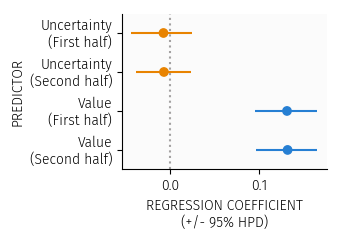

In [13]:
# Remove intercept
summary = split_half_summary

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.scatter(split_half_summary['mean'], range(len(split_half_summary)), color=[pal[0], pal[0], pal[1], pal[1]])
plt.errorbar(split_half_summary['mean'], range(len(split_half_summary)), 
             xerr=[split_half_summary['mean'] - split_half_summary['hpd_2.5'], split_half_summary['hpd_97.5'] - split_half_summary['mean']], 
               fmt='none', label=None, color=[pal[0], pal[0], pal[1], pal[1]])
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 3.5)
plt.yticks(range(len(split_half_summary)), split_half_summary['Parameter'].values)
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("PREDICTOR", fontweight='light')
sns.despine()

plt.tight_layout()
plt.savefig('../figures/eyetracking_model_estimates_split_half.svg', facecolor='#fbfbfb')

## Run a simpler model without an effect of uncertainty

Here we remove the uncertainty term so we're simply predicting fixation bias from value alone to check whether model fit gets any worse.
    

In [14]:
with pm.Model() as fixation_model_simple:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)
    
    # Precision of reparameterised beta
    phi = pm.HalfCauchy('$\phi$', 100)

    # Estimated y values, with logit link function
    y_est = pm.math.invlogit(b_intercept[subject_idx] +
                             b_value[subject_idx] * bias_df['prob_estimate_RL_diff'])
    
    # Beta likelihood
    y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                     observed=bias_df['bias'])
    
with fixation_model_simple:
    approx_simple = pm.fit(n=80000, random_seed=123)
    trace_simple = pm.sample_approx(approx_simple, draws=1000)
    model_waic_simple = pm.waic(trace_simple)

Average Loss = -9,071.1: 100%|██████████████████████████████████████████████████| 80000/80000 [10:38<00:00, 125.39it/s]
Finished [100%]: Average Loss = -9,071.1


### Plot the WAIC scores

WAIC provides an index of model fit - lower values represent better model fit.

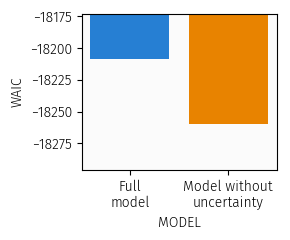

In [15]:
# Make things look nice
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

waics = [model_waic[0], model_waic_simple[0]]

# Plot the WAIC scores for each model
plt.figure(figsize=(3, 2.5), dpi=100)
waic_pal = [pal[0]] * len(waics)
waics = np.array(waics)
winning_idx = np.where(waics == waics.min())[0][0]
waic_pal[winning_idx] = pal[1]
plt.ylim(waics.min() - ((waics.max() - waics.min()) * 0.7), waics.max() + ((waics.max() - waics.min()) * 0.7))
plt.bar(['Full\nmodel', 'Model without\nuncertainty'], waics, color=waic_pal)
plt.ylabel('WAIC', fontweight='light')
plt.xlabel("MODEL", fontweight='light')
plt.tight_layout()

# Save the figure
plt.savefig('../figures/model_comparison_eyetracking.svg', facecolor='#fbfbfb')


## Model using model-derived value rather than reported value

In [16]:
with pm.Model() as fixation_model_value:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Model-derived probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Model-derived probability $\sigma$', 100)
    mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
    sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
    b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)
    
    # Precision of reparameterised beta
    phi = pm.HalfCauchy('$\phi$', 100)

    # Estimated y values, with logit link function
    y_est = pm.math.invlogit(b_intercept[subject_idx] +
                             b_value[subject_idx] * bias_df['model_prob_estimate_RL_diff'] +
                             b_var[subject_idx] * bias_df['var_RL_diff'])
    
    # Beta likelihood
    y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                     observed=bias_df['bias'])

In [17]:
with fixation_model_value:
    approx = pm.fit(n=80000, random_seed=123)
    trace = pm.sample_approx(approx, draws=1000)
    model_waic = pm.waic(trace)

Average Loss = -8,930.8: 100%|███████████████████████████████████████████████████| 80000/80000 [14:40<00:00, 90.91it/s]
Finished [100%]: Average Loss = -8,930.8


In [18]:
full_summary = pm.summary(trace, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Model-derived probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-1.506137,0.016763,0.000504,-1.537849,-1.473957
$\beta$ Model-derived probability $\mu$,0.129095,0.017224,0.000504,0.094001,0.161266
$\beta$ Uncertainty $\mu$,-0.001991,0.017050,0.000522,-0.034455,0.032098


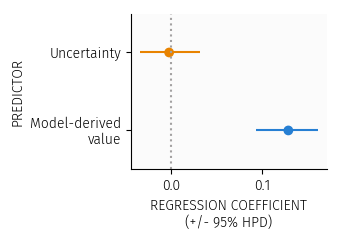

In [19]:
# Remove intercept
summary = full_summary[1:]

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.scatter(summary['mean'], range(len(summary)), color=pal[:3])
plt.errorbar(summary['mean'], range(len(summary)), 
             xerr=[summary['mean'] - summary['hpd_2.5'], summary['hpd_97.5'] - summary['mean']], 
               fmt='none', label=None, color=pal[:3])
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 1.5)
plt.yticks(range(len(summary)), [re.search('[A-Z][a-z -]+', i).group()[:-1].replace(' ', '\n').replace('probability', 'value') for i in summary.index])
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("PREDICTOR", fontweight='light')
sns.despine()

plt.tight_layout()

plt.savefig('../figures/eyetracking_model_estimates_value_from_model.svg', facecolor='#fbfbfb')

## Model including prediction error on the previous trial

In [20]:
with pm.Model() as fixation_model_pe:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
    mu_b_pe = pm.Normal('$\\beta$ Prediction error $\mu$', mu=0., sd=100**2)
    sigma_b_pe = pm.HalfCauchy('$\\beta$ Prediction error $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    pe_offset = pm.Normal('pe_offset', mu=0, sd=1, shape=n_subjects)
    b_pe = pm.Deterministic("b_pe", mu_b_pe + pe_offset * sigma_b_pe)
    
    # Precision of reparameterised beta
    phi = pm.HalfCauchy('$\phi$', 100)

    # Estimated y values, with logit link function
    y_est = pm.math.invlogit(b_intercept[subject_idx] +
                             b_value[subject_idx] * bias_df['prob_estimate_RL_diff'] +
                             b_pe[subject_idx] * bias_df['abs_pe_RL_diff'])
    
    # Beta likelihood
    y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                     observed=bias_df['bias'])

In [21]:
with fixation_model_pe:
    approx = pm.fit(n=80000, random_seed=123)
    trace = pm.sample_approx(approx, draws=1000)
    model_waic = pm.waic(trace)

Average Loss = -8,930.5: 100%|███████████████████████████████████████████████████| 80000/80000 [14:50<00:00, 89.86it/s]
Finished [100%]: Average Loss = -8,930.5


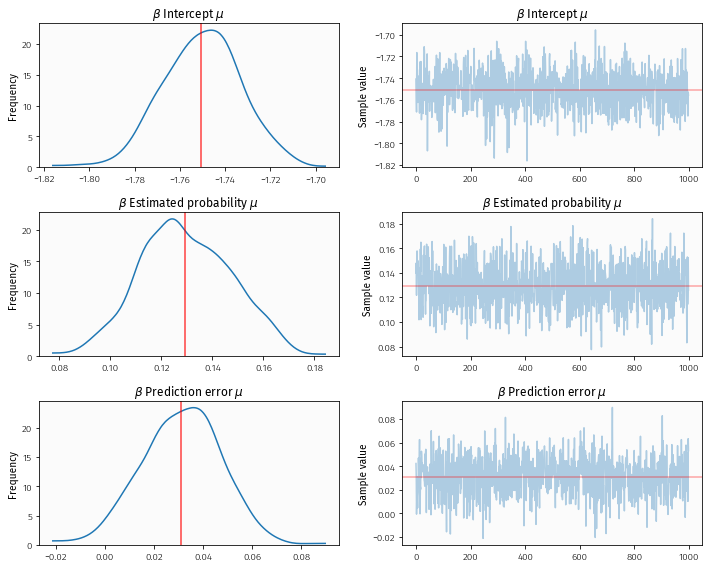

In [22]:
pm.traceplot(trace, lines={'$\\beta$ Intercept $\\mu$':trace['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Estimated probability $\\mu$': trace['$\\beta$ Estimated probability $\\mu$'].mean(),
                           '$\\beta$ Prediction error $\\mu$': trace['$\\beta$ Prediction error $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$', 
                       '$\\beta$ Prediction error $\\mu$'],
             figsize=(10, 8));

In [23]:
full_summary = pm.summary(trace, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Prediction error $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-1.750568,0.017342,0.000522,-1.783377,-1.717276
$\beta$ Estimated probability $\mu$,0.129428,0.017805,0.000487,0.096157,0.164002
$\beta$ Prediction error $\mu$,0.031032,0.016184,0.000507,-0.000337,0.061577


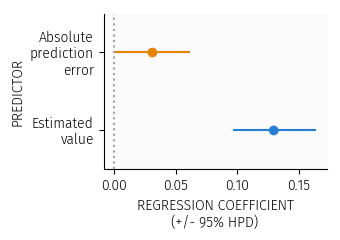

In [24]:
# Remove intercept
summary = full_summary[1:]

# Plot
plt.figure(figsize=(3.5, 2.5), dpi=100)
plt.scatter(summary['mean'], range(len(summary)), color=pal[:3])
plt.errorbar(summary['mean'], range(len(summary)), 
             xerr=[summary['mean'] - summary['hpd_2.5'], summary['hpd_97.5'] - summary['mean']], 
               fmt='none', label=None, color=pal[:3])
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 1.5)
plt.yticks(range(len(summary)), [re.search('[A-Z][a-z ]+', i).group()[:-1].replace(' ', '\n').replace('probability', 'value').replace('Prediction', 'Absolute\nprediction') for i in summary.index])
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("PREDICTOR", fontweight='light')
sns.despine()

plt.tight_layout()

plt.savefig('../figures/eyetracking_model_estimates_prediction_error.svg', facecolor='#fbfbfb')

This demonstrates a weak effect of prediction error on fixation, however the 95% HPDI does still include zero.

## First fixation bias

Here we look at effects of value and uncertainty on the duration of first fixations (i.e. the length of the first fixation on A and B). To get a measure of competitive attention between the two stimuli, we take the difference in first fixation duration between the stimuli and then scale this to have zero mean and unit variance.

In [25]:
bias_df.loc[:, 'first_fix_bias'] = bias_df['l_first_duration'] - bias_df['r_first_duration']
bias_df.loc[bias_df.loc[:, 'first_fix_bias'].isnull(), 'first_fix_bias'] = 0.5
bias_df.loc[:, 'first_fix_bias'] = scale(bias_df['first_fix_bias'].values)

#### Distribution of bias values

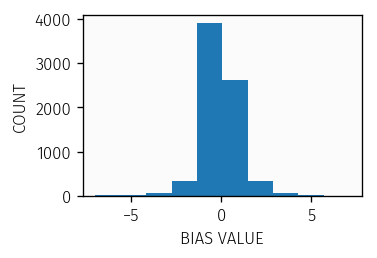

In [26]:
plt.figure(figsize=(3, 2), dpi=120)
plt.hist(bias_df.loc[:, 'first_fix_bias'])
plt.xlabel("BIAS VALUE", fontweight='light')
plt.ylabel("COUNT", fontweight='light');

### Create the model

Here we use a standard hierarchical linear model (i.e. assuming a normally distributed observed variable rather than beta distributed). Again we're predicting fixation bias from value and uncertainty.

In [27]:
subject_idx = bias_df.Subject_idx.values

with pm.Model() as fixation_model_ff:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
    mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
    sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
    b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)
    
    # Error
    eps = pm.HalfCauchy('eps', 5)

    # Estimated y values
    y_est = b_intercept[subject_idx] + b_value[subject_idx] * bias_df['prob_estimate_RL_diff'] + b_var[subject_idx] * bias_df['var_RL_diff']
    
    # Gaussian likelihood
    y_like = pm.Normal('likelihood', y_est, sd=eps, observed=bias_df['first_fix_bias'])

### Fit the model

In [28]:
with fixation_model_ff:
    approx = pm.fit(n=80000, random_seed=123)
    trace = pm.sample_approx(approx, draws=1000)
    model_waic = pm.waic(trace)

Average Loss = 10,425: 100%|████████████████████████████████████████████████████| 80000/80000 [04:19<00:00, 307.99it/s]
Finished [100%]: Average Loss = 10,425
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


### View the results

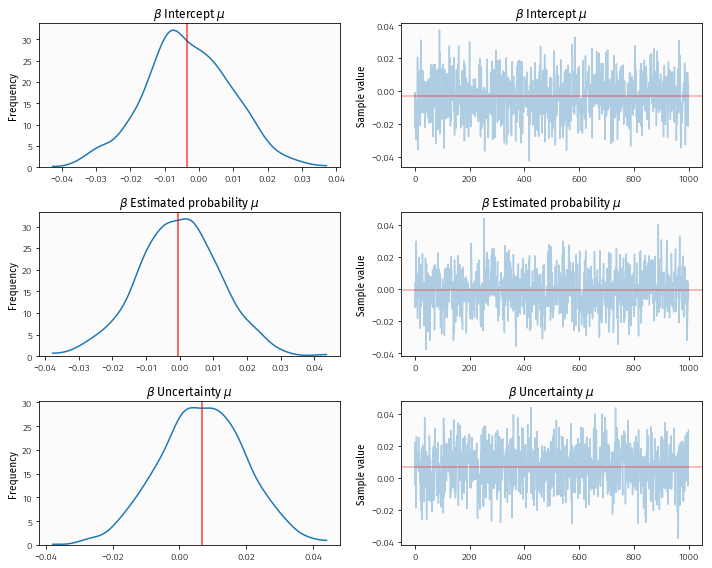

In [29]:
pm.traceplot(trace, lines={'$\\beta$ Intercept $\\mu$':trace['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Estimated probability $\\mu$': trace['$\\beta$ Estimated probability $\\mu$'].mean(),
                           '$\\beta$ Uncertainty $\\mu$': trace['$\\beta$ Uncertainty $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$', 
                       '$\\beta$ Uncertainty $\\mu$'],
             figsize=(10, 8));

In [30]:
full_summary = pm.summary(trace, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-0.003371,0.012552,0.000397,-0.030554,0.019053
$\beta$ Estimated probability $\mu$,-0.000413,0.012064,0.000448,-0.023632,0.023962
$\beta$ Uncertainty $\mu$,0.006654,0.012817,0.000398,-0.017329,0.031874


These all look like fairly solid null effects.

## First fixation location

Here we look at the location of the first fixation, i.e. where subjects choose to fixate first. In the case that they do not fixate on either stimulus, we label the location as NaN.

We analyse this using a hierarchical logistic regression model.

In [31]:
subject_idx = bias_df.Subject_idx.values
bias_df.loc[bias_df['first_fixation_location'] == -1, 'first_fixation_location'] += 1

with pm.Model() as fixation_model_location:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
    mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
    sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
    b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)
    
    # Error
    eps = pm.HalfCauchy('eps', 5)

    # Estimated y values, with logit link function
    y_est = b_intercept[subject_idx] + b_value[subject_idx] * bias_df['prob_estimate_RL_diff'] + b_var[subject_idx] * bias_df['var_RL_diff']
    
    y_est_logit = pm.invlogit(y_est)
    
    # Beta likelihood
    y_like = pm.Bernoulli('likelihood', p=y_est_logit, observed=bias_df['first_fixation_location'])

### Fit the model

In [32]:
with fixation_model_location:
    approx = pm.fit(n=80000, random_seed=123)
    trace_location = pm.sample_approx(approx, draws=1000)

Average Loss = inf: 100%|███████████████████████████████████████████████████████| 80000/80000 [10:22<00:00, 128.61it/s]
Finished [100%]: Average Loss = nan


### Results

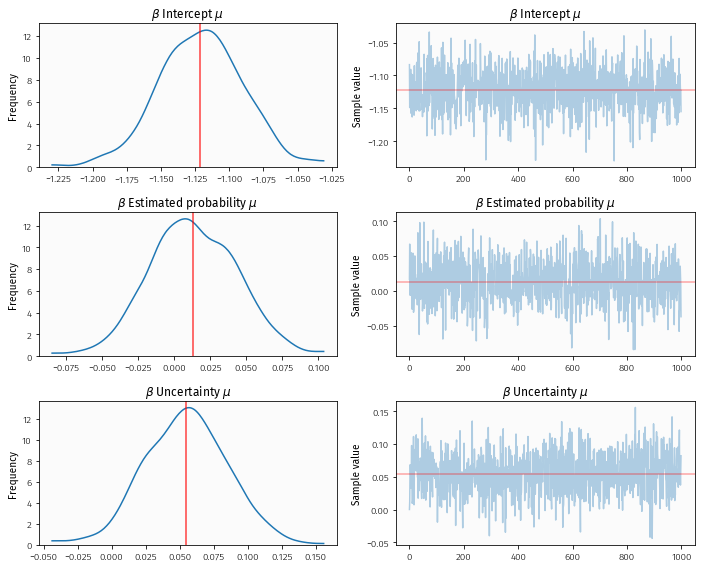

In [33]:
pm.traceplot(trace_location, lines={'$\\beta$ Intercept $\\mu$':trace_location['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Estimated probability $\\mu$': trace_location['$\\beta$ Estimated probability $\\mu$'].mean(),
                           '$\\beta$ Uncertainty $\\mu$': trace_location['$\\beta$ Uncertainty $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$', 
                       '$\\beta$ Uncertainty $\\mu$'],
             figsize=(10, 8));

In [34]:
full_summary = pm.summary(trace_location, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-1.121458,0.031057,0.000942,-1.182367,-1.061106
$\beta$ Estimated probability $\mu$,0.012698,0.030263,0.001019,-0.044865,0.071601
$\beta$ Uncertainty $\mu$,0.054353,0.030274,0.000935,-0.002509,0.114057


Again, there's nothing "significant" here, although is a trend with uncertainty.

# Outcome phase

Now we look at what influences fixations during the outcome phase of the trial. This is where subjects find out whether they're about to be shocked and then receive the shock.

### Process the eye tracking data

In [35]:
# Find subject IDs for those who weren't excluded based on behaviour
subjects = sorted([re.search('\d+', i).group() for i in os.listdir(simulated_dir) if '.txt' in i])
bias_dfs_outcome = []

print "Processing eye tracking data for outcome phase, {0} subjects".format(len(subjects))
for n, sub in enumerate(tqdm(subjects)):
    bias_dfs_outcome.append(process_fixations(sub, n, 0, 7, eyetracking_dir, behavioural_dir, simulated_dir, left_aoi, right_aoi, '_outcome'))

outcome_bias_df = pd.concat([i[0] for i in bias_dfs_outcome if i is not None])
outcome_bias_df.bias[outcome_bias_df.Outcome_image_L == 'B'] = 1 - outcome_bias_df.bias[outcome_bias_df.Outcome_image_L == 'B']  # Flip bias round to line up with behaviour etc

# bias_df
outcome_bias_df.to_csv('outcome_bias_df.csv')

# Exclude subjects
outcome_bias_df = outcome_bias_df[outcome_bias_df['left_proportion'] > 0.2]
outcome_bias_df = outcome_bias_df[outcome_bias_df['right_proportion'] > 0.2]
outcome_bias_df = outcome_bias_df[outcome_bias_df['outside_proportion'] < 0.8]
outcome_bias_df = outcome_bias_df[outcome_bias_df['blink_proportion'] < 0.3]

print "Number of exclusions = {0}".format(len(subjects) - len(outcome_bias_df['Subject'].unique()))

Processing eye tracking data for outcome phase, 48 subjects


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [14:10<00:00, 18.16s/it]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Number of exclusions = 0


### Prepare data for analysis

In [36]:
outcome_bias_df = pd.read_csv('outcome_bias_df.csv')

In [37]:
# Transform our outcome variable so that we can use beta regression, which doesn't accept values of 0 or 1.
outcome_bias_df['bias'] = (outcome_bias_df['bias'] * (len(outcome_bias_df) - 1) + 0.5) / len(outcome_bias_df)

# Create additional predictors
outcome_bias_df['prediction_error_A'] = outcome_bias_df['A_Outcome'] - outcome_bias_df['A_True_response']
outcome_bias_df['prediction_error_B'] = outcome_bias_df['B_Outcome'] - outcome_bias_df['B_True_response']
outcome_bias_df['prediction_error_RL_diff'] = outcome_bias_df['prediction_error_A'] - outcome_bias_df['prediction_error_B']
outcome_bias_df['prediction_error_squared_RL_diff'] = np.power(outcome_bias_df['prediction_error_A'], 2) - np.power(outcome_bias_df['prediction_error_B'], 2)
outcome_bias_df['outcome_RL_diff'] = outcome_bias_df['A_Outcome'] - outcome_bias_df['B_Outcome']

# Scale predictors
outcome_bias_df[['prob_estimate_RL_diff', 'var_RL_diff', 
                 'prediction_error_RL_diff', 'prediction_error_squared_RL_diff', 
                 'outcome_RL_diff']] = scale(outcome_bias_df[['prob_estimate_RL_diff', 'var_RL_diff', 
                 'prediction_error_RL_diff', 'prediction_error_squared_RL_diff', 
                 'outcome_RL_diff']])

# Get number of subjects
n_subjects = len(outcome_bias_df.Subject.unique())

# Create an index variable for subjects
outcome_bias_df['Subject_idx'] = np.arange(n_subjects).repeat(len(outcome_bias_df) / n_subjects)
subject_idx = outcome_bias_df.Subject_idx.values

### Look at the data

A few of our predictors are highly dependent on one another (e.g. outcome, probability estimate, prediction error) so we'll plot correlations between variables to make sure they're not too highly correlated.

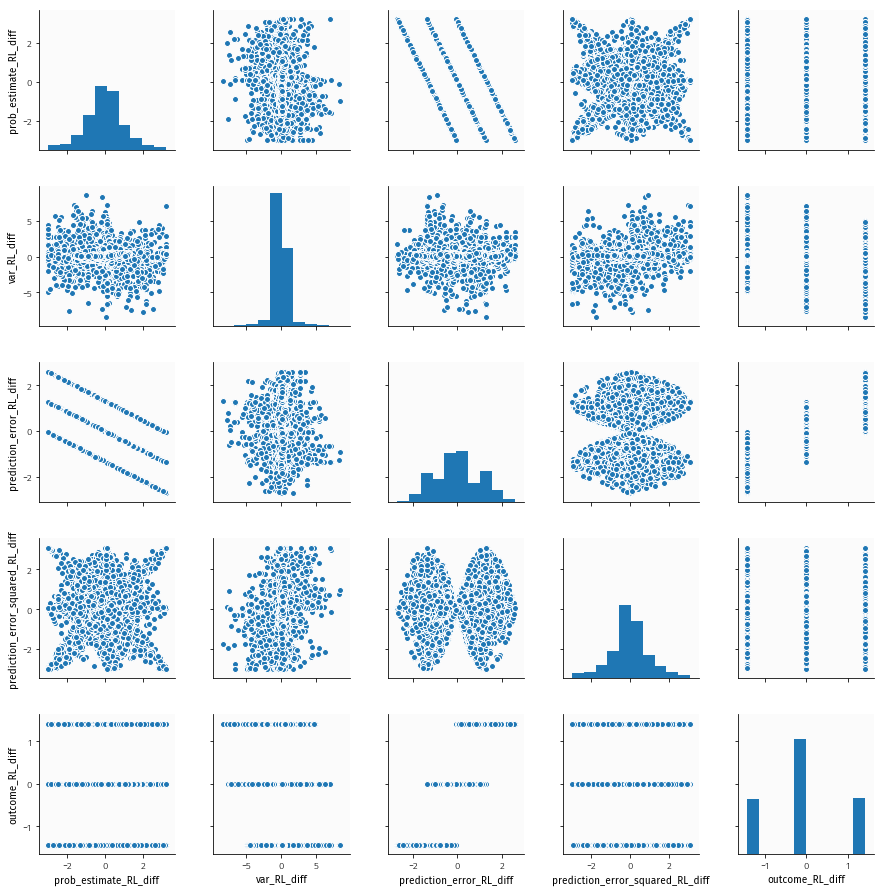

In [38]:
sns.pairplot(outcome_bias_df[['prob_estimate_RL_diff', 'var_RL_diff', 
                 'prediction_error_RL_diff', 'prediction_error_squared_RL_diff', 
                 'outcome_RL_diff']]);

These are some pretty patterns but there doesn't seem to be anything particularly problematic - none of our predictors are extremely highly correlated.

### Specify the model

This model a hierarhical beta regression, similar to the one we used in the pre-outcome phase. However here we can add three additional predictors: **outcome** (shock or no shock), **prediction error** (outcome - predicted probability), and **prediction error²** (corresponding to an unsigned prediction error)

In [39]:
with pm.Model() as fixation_model_outcome:

    # Group-level parameters
    mu_intercept = pm.Normal('$\\beta$ Intercept $\mu$', mu=0., sd=100**2)
    sigma_intercept = pm.HalfCauchy('$\\beta$_Intercept $\sigma$', 100)
    mu_b_value = pm.Normal('$\\beta$ Estimated probability $\mu$', mu=0., sd=100**2)
    sigma_b_value = pm.HalfCauchy('$\\beta$ Estimated probability $\sigma$', 100)
    mu_b_var = pm.Normal('$\\beta$ Uncertainty $\mu$', mu=0., sd=100**2)
    sigma_b_var = pm.HalfCauchy('$\\beta$ Uncertainty $\sigma$', 100)
    mu_b_outcome = pm.Normal('$\\beta$ Outcome $\mu$', mu=0., sd=100**2)
    sigma_b_outcome = pm.HalfCauchy('$\\beta$ Outcome $\sigma$', 100)
    mu_b_pe = pm.Normal('$\\beta$ Prediction error $\mu$', mu=0., sd=100**2)
    sigma_b_pe = pm.HalfCauchy('$\\beta$ Prediction error $\sigma$', 100)
    mu_b_pe2 = pm.Normal('$\\beta$ Prediction error^2 $\mu$', mu=0., sd=100**2)
    sigma_b_pe2 = pm.HalfCauchy('$\\beta$ Prediction error^2 $\sigma$', 100)

    # Individual-level betas - using non-centered reparameterisation
    intercept_offset = pm.Normal('intercept_offset', mu=0, sd=1, shape=n_subjects)
    b_intercept = pm.Deterministic("b_intercept", mu_intercept + intercept_offset * sigma_intercept)

    value_offset = pm.Normal('value_offset', mu=0, sd=1, shape=n_subjects)
    b_value = pm.Deterministic("b_value", mu_b_value + value_offset * sigma_b_value)

    var_offset = pm.Normal('var_offset', mu=0, sd=1, shape=n_subjects)
    b_var = pm.Deterministic("b_var", mu_b_var + var_offset * sigma_b_var)
    
    outcome_offset = pm.Normal('outcome_offset', mu=0, sd=1, shape=n_subjects)
    b_outcome = pm.Deterministic("b_outcome", mu_b_outcome + outcome_offset * sigma_b_outcome)

    pe_offset = pm.Normal('pe_offset', mu=0, sd=1, shape=n_subjects)
    b_pe = pm.Deterministic("b_pe", mu_b_pe + pe_offset * sigma_b_pe)
    
    pe2_offset = pm.Normal('pe_offset2', mu=0, sd=1, shape=n_subjects)
    b_pe2 = pm.Deterministic("b_pe2", mu_b_pe2 + pe2_offset * sigma_b_pe2)
    
    # Precision of reparameterised beta
    phi = pm.HalfCauchy('$\phi$', 100)

    # Estimated y values, with logit link function
    y_est = pm.math.invlogit(b_intercept[subject_idx] +
                             b_value[subject_idx] * outcome_bias_df['prob_estimate_RL_diff'] +
                             b_var[subject_idx] * outcome_bias_df['var_RL_diff'] +
                             b_pe[subject_idx] * outcome_bias_df['prediction_error_RL_diff'] +
                             b_pe2[subject_idx] * outcome_bias_df['prediction_error_squared_RL_diff'] +
                             b_outcome[subject_idx] * outcome_bias_df['outcome_RL_diff'])
    
    # Beta likelihood
    y_like = pm.Beta('likelihood', alpha=y_est * phi, beta=(1 - y_est) * phi,
                     observed=outcome_bias_df['bias'])

### Fit the model

In [40]:
with fixation_model_outcome:
    approx = pm.fit(n=80000, random_seed=123)
    trace_outcome = pm.sample_approx(approx, draws=1000)

Average Loss = -339.71: 100%|████████████████████████████████████████████████████| 80000/80000 [18:11<00:00, 68.43it/s]
Finished [100%]: Average Loss = -339.75


### Results

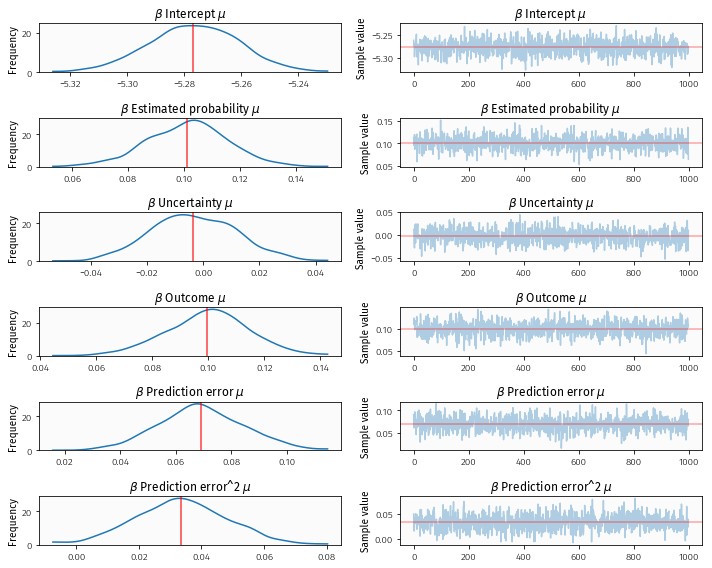

In [41]:
pm.traceplot(trace_outcome, lines={'$\\beta$ Intercept $\\mu$':trace_outcome['$\\beta$ Intercept $\\mu$'].mean(),
                           '$\\beta$ Estimated probability $\\mu$': trace_outcome['$\\beta$ Estimated probability $\\mu$'].mean(),
                           '$\\beta$ Uncertainty $\\mu$': trace_outcome['$\\beta$ Uncertainty $\\mu$'].mean(),
                           '$\\beta$ Outcome $\\mu$': trace_outcome['$\\beta$ Outcome $\\mu$'].mean(),
                           '$\\beta$ Prediction error $\\mu$': trace_outcome['$\\beta$ Prediction error $\\mu$'].mean(),
                           '$\\beta$ Prediction error^2 $\\mu$': trace_outcome['$\\beta$ Prediction error^2 $\\mu$'].mean()},
             varnames=['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$', 
                       '$\\beta$ Uncertainty $\\mu$', '$\\beta$ Outcome $\\mu$', '$\\beta$ Prediction error $\\mu$', '$\\beta$ Prediction error^2 $\\mu$'],
             figsize=(10, 8));

In [42]:
full_summary = pm.summary(trace_outcome, ['$\\beta$ Intercept $\\mu$', '$\\beta$ Estimated probability $\\mu$',
                       '$\\beta$ Uncertainty $\\mu$', '$\\beta$ Outcome $\\mu$', '$\\beta$ Prediction error $\\mu$', '$\\beta$ Prediction error^2 $\\mu$'])
full_summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\beta$ Intercept $\mu$,-5.276815,0.015679,0.000510,-5.306475,-5.245379
$\beta$ Estimated probability $\mu$,0.101143,0.014431,0.000443,0.070620,0.127406
$\beta$ Uncertainty $\mu$,-0.003522,0.015116,0.000458,-0.031009,0.028051
$\beta$ Outcome $\mu$,0.099652,0.014801,0.000472,0.070822,0.129197
$\beta$ Prediction error $\mu$,0.068977,0.015193,0.000476,0.040975,0.099650
$\beta$ Prediction error^2 $\mu$,0.033436,0.014719,0.000492,0.001813,0.058607


This demonstrates effects of every predictor other than uncertainty

### Make a nice figure

This plots the effects of all the predictors on fixation bias.

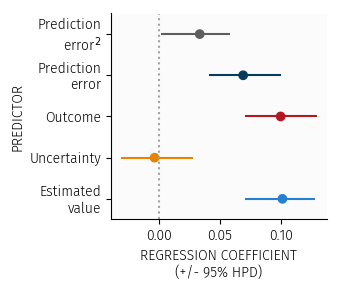

In [43]:
# Remove intercept
summary = full_summary[1:]

# Plot
plt.figure(figsize=(3.5, 3), dpi=100)
plt.scatter(summary['mean'], range(len(summary)), color=pal)
plt.errorbar(summary['mean'], range(len(summary)), 
             xerr=[summary['mean'] - summary['hpd_2.5'], summary['hpd_97.5'] - summary['mean']], 
               fmt='none', label=None, color=pal)
plt.axvline(0, linestyle=':', color='#a3a1a1')

# Axes
plt.ylim(-0.5, 4.5)
plt.yticks(range(len(summary)), [re.search('[A-Z][a-z ^2]+', i).group()[:-1].replace(' ', '\n').replace('^2', '$^2$').replace('probability', 'value') for i in summary.index])
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD)", fontweight='light')
plt.ylabel("PREDICTOR", fontweight='light')
sns.despine()

plt.tight_layout()

plt.savefig('../figures/eyetracking_model_estimates_outcome.svg', facecolor='#fbfbfb')